In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import silhouette_score
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import umap
from tqdm import tqdm

In [3]:
base_path = "/content/drive/MyDrive/caltech"

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

CLASSES = ["sunflower", "panda", "kangaroo", "flamingo", "elephant", "butterfly"]

IMG_SIZE = (128, 128)

def load_images_from_folder(folder_path):
    X = []
    y = []

    for fname in os.listdir(folder_path):
        if fname.lower().endswith(("jpg", "jpeg", "png")):

            # Extract base name (no extension)
            base = os.path.splitext(fname)[0].lower()

            # Find matching class
            label = None
            for cls in CLASSES:
                if base.startswith(cls):
                    label = cls
                    break

            # If no class matched, skip this file completely
            if label is None:
                print("WARNING: No class matched for file:", fname)
                continue

            # NOTE: Load image ONLY after we know label is valid
            img = load_img(os.path.join(folder_path, fname),
                           color_mode="grayscale",
                           target_size=IMG_SIZE)
            arr = img_to_array(img).astype("float32") / 255.0

            # Append both X and y together
            X.append(arr.flatten())
            y.append(label)

    return np.array(X), np.array(y)


X, y = load_images_from_folder(base_path)

# === CHECK LABELS HERE ===
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Unique labels:", np.unique(y))
print("Number of unique classes:", len(np.unique(y)))
print("First 10 labels:", y[:10])


Shape of X: (221, 16384)
Shape of y: (221,)
Unique labels: ['butterfly' 'elephant' 'flamingo' 'kangaroo' 'panda' 'sunflower']
Number of unique classes: 6
First 10 labels: ['butterfly' 'butterfly' 'butterfly' 'butterfly' 'butterfly' 'butterfly'
 'butterfly' 'butterfly' 'butterfly' 'butterfly']


# Q1 - PCA 95% Variance

In [5]:
pca = PCA().fit(X)

cumvar = np.cumsum(pca.explained_variance_ratio_)
k = np.searchsorted(cumvar, 0.95) + 1
print(f"95% variance: {k} components")

95% variance: 133 components


# Q2 Original vs PCA Reconstruction

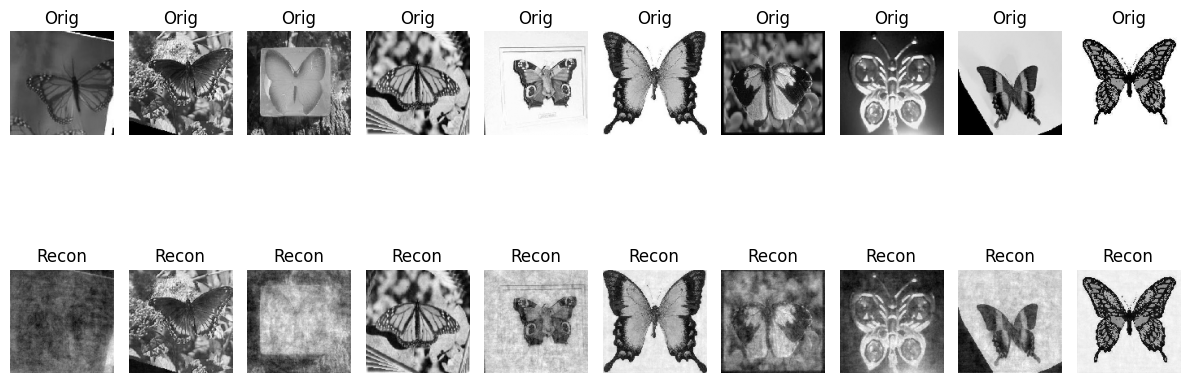

In [6]:
X_real, y_real = X,y

pca_real = PCA(n_components=133)
X_real_pca = pca_real.fit_transform(X_real)
X_real_recon = pca_real.inverse_transform(X_real_pca)

# Plot 10 images
plt.figure(figsize=(12, 6))

for i in range(10):
    # Original
    plt.subplot(2, 10, i+1)
    plt.imshow(X_real[i].reshape(IMG_SIZE), cmap="gray")
    plt.axis("off")
    plt.title("Orig")

    # Reconstructed
    plt.subplot(2, 10, i+11)
    plt.imshow(X_real_recon[i].reshape(IMG_SIZE), cmap="gray")
    plt.axis("off")
    plt.title("Recon")
plt.tight_layout()
plt.show()

# Q3 - 2D PCA, t-SNE, LLE, UMAP

A) Reduce to 2D + Variance

In [7]:
def pca_2d(X):
    p = PCA(n_components=2)
    X2 = p.fit_transform(X)
    var = p.explained_variance_ratio_.sum()
    return X2, var

X_pca2, var = pca_2d(X)
print(f"PCA-2D explains {var*100:.2f}% variance")

PCA-2D explains 39.44% variance


In [8]:
print(np.unique(y))

['butterfly' 'elephant' 'flamingo' 'kangaroo' 'panda' 'sunflower']


3 B) Plot Function

In [10]:
def plot_embedding(X2, y, title):
    labels = np.unique(y)
    plt.figure(figsize=(7,5))
    for lab in labels:
        idx = (y == lab)
        plt.scatter(X2[idx,0], X2[idx,1], label=lab, s=20)
    plt.legend()
    plt.title(title)
    plt.show()

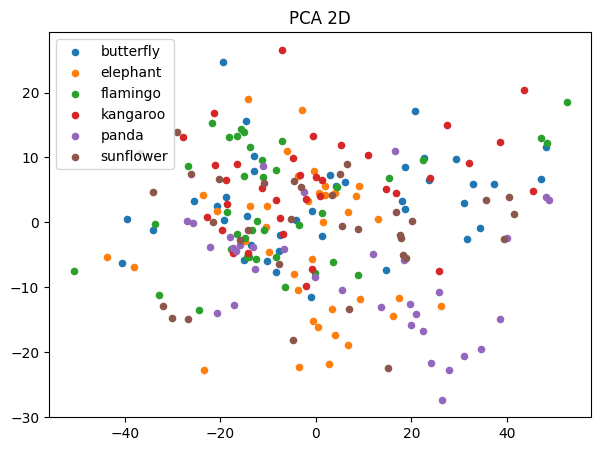

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


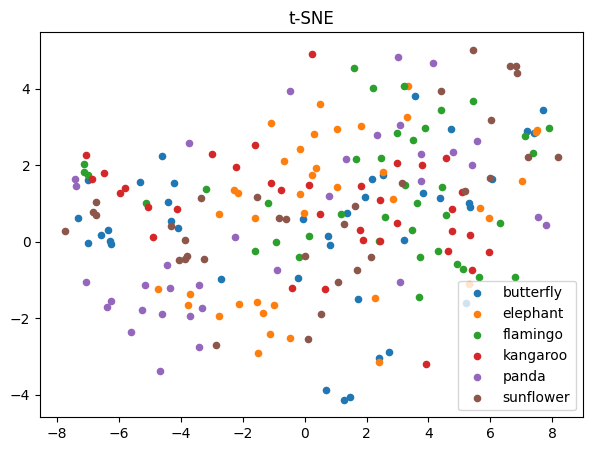

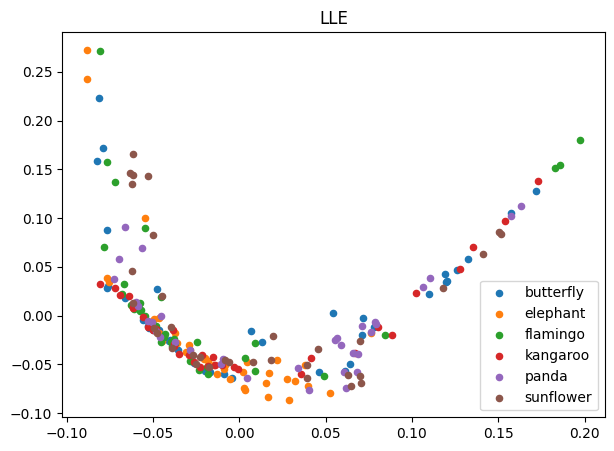

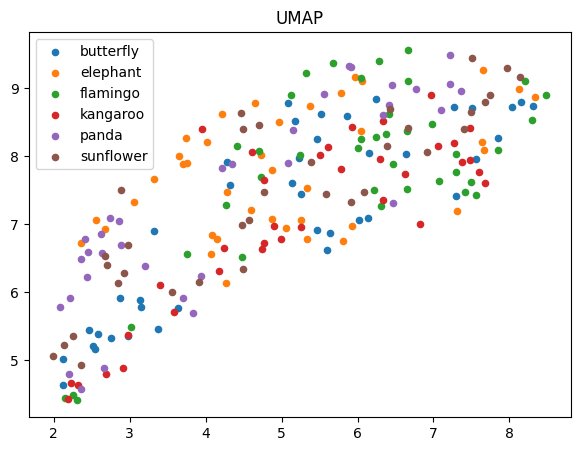

In [11]:
# PCA-2
plot_embedding(X_pca2, y, f"PCA 2D")

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, y, f"t-SNE")

# LLE
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=12)
X_lle = lle.fit_transform(X)
plot_embedding(X_lle, y, f"LLE")

# UMAP
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)
#X_umap = umap.UMAP(n_components=2).fit_transform(X)

plot_embedding(X_umap, y, f"UMAP")

# Q4 - K-Means Clustering

4.A ) Find Best k

PCA components for 95% variance: 133


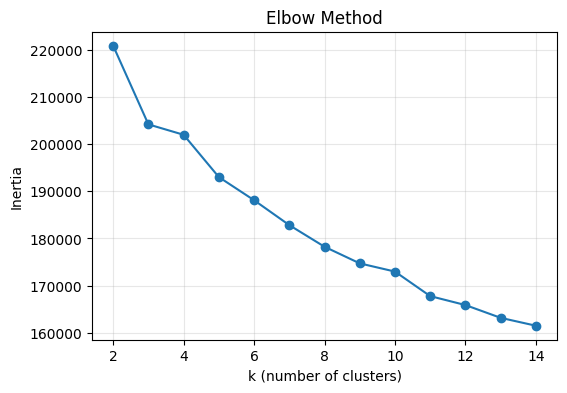

In [12]:
def find_k_elbow(X):
    inertias = []
    ks = range(2, 15)   # test k = 2..14
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        inertias.append(km.inertia_)
    return ks, inertias

# 1. PCA: Keep 95% variance (determine required components)
pca_temp = PCA().fit(X)
cumvar = np.cumsum(pca_temp.explained_variance_ratio_)
k95 = np.searchsorted(cumvar, 0.95) + 1   # components for 95% variance

print("PCA components for 95% variance:", k95)

# Fit PCA with k95 components
pca = PCA(n_components=k95)
X_pca = pca.fit_transform(X)

# 2. Elbow method on PCA-reduced data to choose K for K-Means
ks, inertias = find_k_elbow(X_pca)

# Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title(f"Elbow Method")
plt.grid(alpha=0.3)
plt.show()

4.B) Run PCA → KMeans → Evaluate

Accuracy: 0.3212669683257919


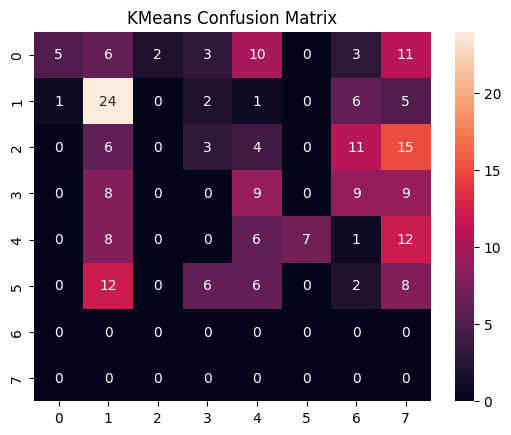

In [13]:
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    labels = np.unique(y_true)
    label_to_int = {lab:i for i,lab in enumerate(labels)}
    y_true_int = np.array([label_to_int[l] for l in y_true])
    # confusion matrix
    C = confusion_matrix(y_true_int, y_pred)

    # Hungarian method
    row_ind, col_ind = linear_sum_assignment(-C)
    acc = C[row_ind, col_ind].sum() / C.sum()
    return acc, C

# PCA 95% reduction
pca = PCA(n_components=k95)
Xp = pca.fit_transform(X)

# Set clusters = 8
km = KMeans(n_clusters=8)
pred = km.fit_predict(Xp)

# Evaluate
acc, C = clustering_accuracy(y, pred)
print("Accuracy:", acc)
sns.heatmap(C, annot=True, fmt="d")
plt.title(f"KMeans Confusion Matrix")
plt.show()

4C - K-Means Using ResNet Features

Extract ResNet Embeddings

In [14]:
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg")

def extract_resnet_features(X_raw):
    imgs = []
    for x in X_raw:
        img = x.reshape(IMG_SIZE)
        img = tf.image.resize(img[...,None], (224,224))
        img = tf.image.grayscale_to_rgb(img)
        imgs.append(img.numpy())
    imgs = np.array(imgs)
    imgs = preprocess_input(imgs)
    feats = resnet.predict(imgs, verbose=0)
    return feats

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Evaluate ResNet + K-Means

Accuracy: 0.3031674208144796


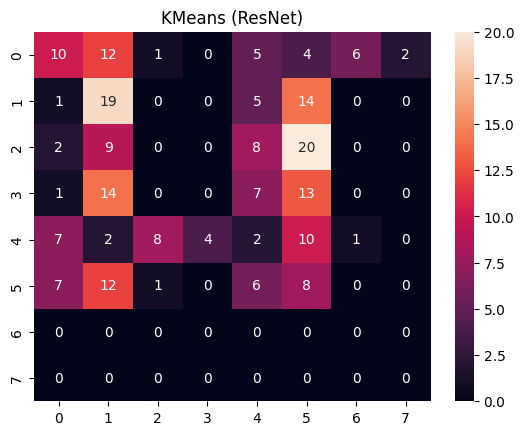

In [15]:
feats = extract_resnet_features(X)

km = KMeans(n_clusters=8)
pred = km.fit_predict(feats)

acc, C = clustering_accuracy(y, pred)
print("Accuracy:", acc)
sns.heatmap(C, annot=True, fmt="d")
plt.title(f"KMeans (ResNet)")
plt.show()


5) EM (Gaussian Mixture Models)

5A. Choose number of components with BIC

In [16]:
def gmm_bic_selection(X_pca, K_range=range(1, 15)):
    bics = []
    for k in K_range:
        gmm = GaussianMixture(n_components=k, covariance_type="full",
                              random_state=42)
        gmm.fit(X_pca)
        bics.append(gmm.bic(X_pca))
        #print(f"K={k:2d}  BIC={bics[-1]:.1f}")
    return list(K_range), bics

PCA components for 95% variance: 133


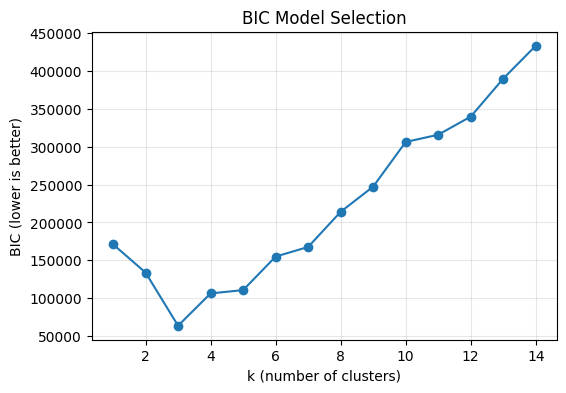

In [18]:
# 1. PCA: keep 95% variance
pca_temp = PCA().fit(X)
cumvar = np.cumsum(pca_temp.explained_variance_ratio_)
k95 = np.searchsorted(cumvar, 0.95) + 1
print("PCA components for 95% variance:", k95)

pca = PCA(n_components=k95)
X_pca = pca.fit_transform(X)

# 2. BIC method for GMM clustering
Ks, bics = gmm_bic_selection(X_pca)

# Plot BIC curve
plt.figure(figsize=(6,4))
plt.plot(Ks, bics, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("BIC (lower is better)")
plt.title(f"BIC Model Selection")
plt.grid(alpha=0.3)
plt.show()

5B. GMM with K=8, accuracy & confusion matrix

In [19]:
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(y_true, y_pred):
    labels = np.unique(y_true)
    label_to_int = {lab:i for i,lab in enumerate(labels)}
    y_true_int = np.array([label_to_int[l] for l in y_true])

    C = confusion_matrix(y_true_int, y_pred)

    # Hungarian alignment
    row_ind, col_ind = linear_sum_assignment(-C)
    acc = C[row_ind, col_ind].sum() / C.sum()

    return acc, C

Accuracy: 0.27149321266968324


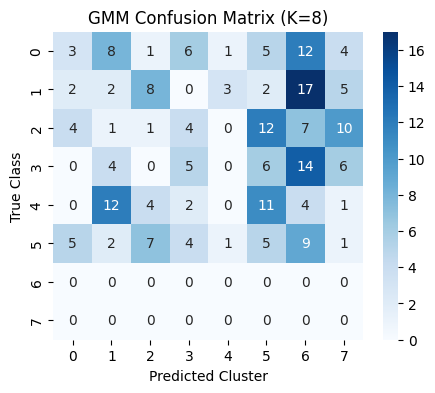

In [20]:
# PCA 95% reduction
pca_temp = PCA().fit(X)
cumvar = np.cumsum(pca_temp.explained_variance_ratio_)
k95 = np.searchsorted(cumvar, 0.95) + 1

pca = PCA(n_components=k95)
X_pca = pca.fit_transform(X)

# Fit GMM with K=8 clusters
gmm = GaussianMixture(n_components=8, covariance_type="full",
                      random_state=42)
pred = gmm.fit_predict(X_pca)

# Evaluate with Hungarian mapping
acc, C = clustering_accuracy(y, pred)
print("Accuracy:", acc)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(C, annot=True, fmt="d", cmap="Blues")
plt.title(f"GMM Confusion Matrix (K=8)")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Class")
plt.show()

5C. Sample new images from GMM and reconstruct

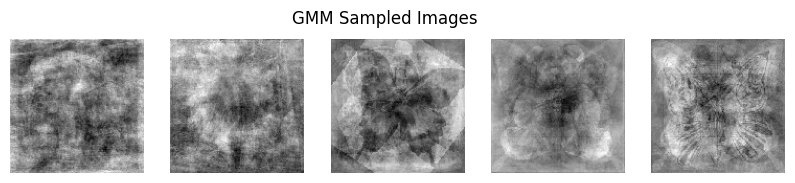

In [21]:
pca = PCA(n_components=k95)
Xp = pca.fit_transform(X)

gmm = GaussianMixture(n_components=8).fit(Xp)

samples = gmm.sample(5)[0]
recon = pca.inverse_transform(samples)

plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(recon[i].reshape(IMG_SIZE), cmap="gray")
    plt.axis("off")
plt.suptitle(f"GMM Sampled Images")
plt.show()


5D. GMM with ResNet features

Accuracy: 0.2986425339366516


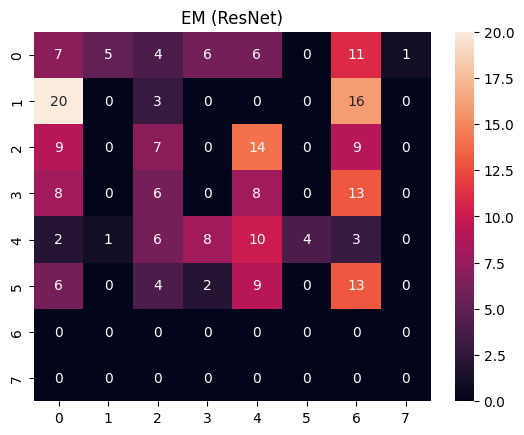

In [22]:
feats = extract_resnet_features(X)

gmm = GaussianMixture(n_components=8)
pred = gmm.fit_predict(feats)

acc, C = clustering_accuracy(y, pred)
print("Accuracy:", acc)
sns.heatmap(C, annot=True, fmt="d")
plt.title(f"EM (ResNet)")
plt.show()